# Airfare Markets Under Pressure — EDA & Insights

**Objective:** Analyze when, where, and why airfares differ across U.S. domestic markets, and how city-level characteristics influence route-level prices. Deliver actionable insights for travelers, industry stakeholders, and policymakers.

**Data:** U.S. DOT Domestic Airline Consumer Airfare Report (2021–2025 Q2)

## 1. Setup & Data Load

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = (10, 5)
sns.set_theme(style='whitegrid')

# Load CSV
DATA_PATH = 'airline_ticket_dataset.csv'
df = pd.read_csv(DATA_PATH)

# Convert dollar and comma-formatted columns to numeric (CSV may have $ and ",")
def to_numeric(ser):
    if ser.dtype == object:
        return pd.to_numeric(ser.astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False), errors='coerce')
    return ser
for col in ['fare', 'fare_lg', 'fare_low', 'passengers', 'nsmiles']:
    if col in df.columns:
        df[col] = to_numeric(df[col])

print('Shape:', df.shape)
print('\nColumns:', list(df.columns))
df.head(10)

Shape: (14004, 21)

Columns: ['Year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'city1', 'city2', 'nsmiles', 'passengers', 'fare', 'carrier_lg', 'large_ms', 'fare_lg', 'carrier_low', 'lf_ms', 'fare_low', 'TotalFaredPax_city1', 'TotalPerLFMkts_city1', 'TotalPerPrem_city1', 'TotalFaredPax_city2', 'TotalPerLFMkts_city2', 'TotalPerPrem_city2']


,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,TotalFaredPax_city1,TotalPerLFMkts_city1,TotalPerPrem_city1,TotalFaredPax_city2,TotalPerLFMkts_city2,TotalPerPrem_city2
0,2025,2,32467,31703,"Miami, FL (Metropolitan Area)","New York City, NY (Metropolitan Area)",1118,17955,208.52,B6,0.2551,191.48,B6,0.2551,191.48,4.322090e+06,0.885900,-0.065800,2.978413e+06,0.821150,-0.032867
1,2025,2,32575,32457,"Los Angeles, CA (Metropolitan Area)","San Francisco, CA (Metropolitan Area)",372,17310,157.68,WN,0.5006,169.03,AS,0.1193,140.59,2.822942e+06,0.865080,-0.038060,3.284783e+06,0.880833,-0.051467
2,2025,2,32575,31703,"Los Angeles, CA (Metropolitan Area)","New York City, NY (Metropolitan Area)",2510,13648,430.38,DL,0.2535,526.21,B6,0.2272,365.63,2.822942e+06,0.865080,-0.038060,2.978413e+06,0.821150,-0.032867
3,2025,2,31703,31454,"New York City, NY (Metropolitan Area)","Orlando, FL",989,12627,186.50,B6,0.3735,186.10,B6,0.3735,186.10,2.978413e+06,0.821150,-0.032867,8.664260e+06,0.979700,-0.115500
4,2025,2,30977,31703,"Chicago, IL","New York City, NY (Metropolitan Area)",773,11284,221.33,UA,0.4328,238.62,AA,0.2426,217.36,5.402975e+06,0.775150,-0.007850,2.978413e+06,0.821150,-0.032867
5,2025,2,31703,32457,"New York City, NY (Metropolitan Area)","San Francisco, CA (Metropolitan Area)",2619,9663,452.08,UA,0.3418,520.87,AS,0.1619,313.36,2.978413e+06,0.821150,-0.032867,3.284783e+06,0.880833,-0.051467
6,2025,2,30397,31703,"Atlanta, GA (Metropolitan Area)","New York City, NY (Metropolitan Area)",795,8856,216.49,DL,0.5459,260.13,F9,0.1124,121.46,7.640240e+06,0.869200,0.127000,2.978413e+06,0.821150,-0.032867
7,2025,2,32575,30559,"Los Angeles, CA (Metropolitan Area)","Seattle, WA",978,7594,195.73,AS,0.6003,201.02,AS,0.6003,201.02,2.822942e+06,0.865080,-0.038060,6.438890e+06,0.561400,-0.063500
8,2025,2,31703,34027,"New York City, NY (Metropolitan Area)","West Palm Beach/Palm Beach, FL",1056,7054,223.88,B6,0.4850,208.07,B6,0.4850,208.07,2.978413e+06,0.821150,-0.032867,1.716910e+06,0.805100,0.102000
9,2025,2,30721,30852,"Boston, MA (Metropolitan Area)","Washington, DC (Metropolitan Area)",418,6898,191.75,WN,0.2454,184.34,B6,0.1727,180.01,2.777003e+06,0.892133,-0.023633,3.435623e+06,0.659900,0.045200


In [14]:
# Basic info and missing values
df.info()
print('\nMissing values:')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  14004 non-null  int64  
 1   quarter               14004 non-null  int64  
 2   citymarketid_1        14004 non-null  int64  
 3   citymarketid_2        14004 non-null  int64  
 4   city1                 14004 non-null  object 
 5   city2                 14004 non-null  object 
 6   nsmiles               14004 non-null  int64  
 7   passengers            14004 non-null  int64  
 8   fare                  14004 non-null  float64
 9   carrier_lg            14004 non-null  object 
 10  large_ms              14004 non-null  float64
 11  fare_lg               14004 non-null  float64
 12  carrier_low           14004 non-null  object 
 13  lf_ms                 14004 non-null  float64
 14  fare_low              14004 non-null  float64
 15  TotalFaredPax_city1

## 2. Data Cleaning & Column Mapping

Standardize column names for analysis (adjust if your dataset uses different names).

In [15]:
# Inspect column names (run once, then map to standard names if needed)
for c in df.columns:
    print(repr(c), '->', df[c].dtype, '| sample:', df[c].dropna().iloc[0] if df[c].notna().any() else 'N/A')

'Year' -> int64 | sample: 2025
'quarter' -> int64 | sample: 2
'citymarketid_1' -> int64 | sample: 32467
'citymarketid_2' -> int64 | sample: 31703
'city1' -> object | sample: Miami, FL (Metropolitan Area)
'city2' -> object | sample: New York City, NY (Metropolitan Area)
'nsmiles' -> int64 | sample: 1118
'passengers' -> int64 | sample: 17955
'fare' -> float64 | sample: 208.52
'carrier_lg' -> object | sample: B6
'large_ms' -> float64 | sample: 0.2551
'fare_lg' -> float64 | sample: 191.48
'carrier_low' -> object | sample: B6
'lf_ms' -> float64 | sample: 0.2551
'fare_low' -> float64 | sample: 191.48
'TotalFaredPax_city1' -> float64 | sample: 4322090.0
'TotalPerLFMkts_city1' -> float64 | sample: 0.8859
'TotalPerPrem_city1' -> float64 | sample: -0.0658
'TotalFaredPax_city2' -> float64 | sample: 2978413.33333333
'TotalPerLFMkts_city2' -> float64 | sample: 0.821149999999999
'TotalPerPrem_city2' -> float64 | sample: -0.0328666666666666


In [16]:
# Map to standard names (includes this dataset's columns: city1, city2, fare, nsmiles, etc.)
col_map = {
    'city1': 'origin', 'city2': 'dest',
    'Origin': 'origin', 'Origin City': 'origin_city', 'Origin Airport': 'origin',
    'Destination': 'dest', 'Destination City': 'dest_city', 'Destination Airport': 'dest',
    'fare': 'avg_fare', 'Average Fare': 'avg_fare', 'Fare': 'avg_fare', 'Avg Fare': 'avg_fare', 'Average Fare ($)': 'avg_fare',
    'Passengers': 'passengers', 'Passenger Count': 'passengers', 'Total Passengers': 'passengers',
    'quarter': 'quarter', 'Quarter': 'quarter', 'Year': 'year', 'Year-Quarter': 'year_quarter',
    'nsmiles': 'distance', 'Distance': 'distance', 'Miles': 'distance', 'Market Distance': 'distance',
    'carrier_lg': 'dominant_carrier', 'large_ms': 'dom_share', 'Dominant Carrier': 'dominant_carrier', 'Dominant Carrier Share': 'dom_share', 'Market Share': 'dom_share',
    'carrier_low': 'lowest_fare_carrier', 'lf_ms': 'lcc_share', 'Low Cost Carrier': 'lcc', 'LCC': 'lcc', 'LCC Penetration': 'lcc_penetration',
    'Lowest Fare Carrier': 'lowest_fare_carrier', 'Carriers': 'carriers', 'Number of Carriers': 'n_carriers',
}
rename = {k: v for k, v in col_map.items() if k in df.columns}
if rename:
    df = df.rename(columns=rename)
print('Columns after mapping:', list(df.columns))
df.head(5)

Columns after mapping: ['year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'origin', 'dest', 'distance', 'passengers', 'avg_fare', 'dominant_carrier', 'dom_share', 'fare_lg', 'lowest_fare_carrier', 'lcc_share', 'fare_low', 'TotalFaredPax_city1', 'TotalPerLFMkts_city1', 'TotalPerPrem_city1', 'TotalFaredPax_city2', 'TotalPerLFMkts_city2', 'TotalPerPrem_city2']


,year,quarter,citymarketid_1,citymarketid_2,origin,dest,distance,passengers,avg_fare,dominant_carrier,dom_share,fare_lg,lowest_fare_carrier,lcc_share,fare_low,TotalFaredPax_city1,TotalPerLFMkts_city1,TotalPerPrem_city1,TotalFaredPax_city2,TotalPerLFMkts_city2,TotalPerPrem_city2
0,2025,2,32467,31703,"Miami, FL (Metropolitan Area)","New York City, NY (Metropolitan Area)",1118,17955,208.52,B6,0.2551,191.48,B6,0.2551,191.48,4.322090e+06,0.88590,-0.065800,2.978413e+06,0.821150,-0.032867
1,2025,2,32575,32457,"Los Angeles, CA (Metropolitan Area)","San Francisco, CA (Metropolitan Area)",372,17310,157.68,WN,0.5006,169.03,AS,0.1193,140.59,2.822942e+06,0.86508,-0.038060,3.284783e+06,0.880833,-0.051467
2,2025,2,32575,31703,"Los Angeles, CA (Metropolitan Area)","New York City, NY (Metropolitan Area)",2510,13648,430.38,DL,0.2535,526.21,B6,0.2272,365.63,2.822942e+06,0.86508,-0.038060,2.978413e+06,0.821150,-0.032867
3,2025,2,31703,31454,"New York City, NY (Metropolitan Area)","Orlando, FL",989,12627,186.50,B6,0.3735,186.10,B6,0.3735,186.10,2.978413e+06,0.82115,-0.032867,8.664260e+06,0.979700,-0.115500
4,2025,2,30977,31703,"Chicago, IL","New York City, NY (Metropolitan Area)",773,11284,221.33,UA,0.4328,238.62,AA,0.2426,217.36,5.402975e+06,0.77515,-0.007850,2.978413e+06,0.821150,-0.032867


## 3. When Do Fares Differ? — Temporal Patterns

In [ ]:
# Identify fare and time columns (use actual names from your data)
fare_col = next((c for c in df.columns if 'fare' in c.lower() or 'fare' in c), df.columns[0])
time_cols = [c for c in df.columns if any(x in c.lower() for x in ['year','quarter','date','q'])]
print('Fare column:', fare_col, '| Time-related columns:', time_cols)

# Aggregate average fare by year/quarter if available (compatible across pandas versions)
if time_cols:
    gb = df.groupby(time_cols, dropna=False)[fare_col]
    agg = gb.mean().reset_index().rename(columns={fare_col: 'mean'})
    agg['median'] = gb.median().values
    agg['count'] = gb.count().values
    print(agg.head(15))
else:
    print('No obvious time column found. Show numeric columns:', df.select_dtypes(include=[np.number]).columns.tolist())

Fare column: avg_fare | Time-related columns: ['year', 'quarter']
    year  quarter        mean   median  count
0   2022        1  209.190030  199.570   1000
1   2022        2  250.235335  232.300   1001
2   2022        3  236.135220  220.210   1000
3   2022        4  244.739260  231.910   1000
4   2023        1  237.836560  227.045   1000
5   2023        2  240.884436  229.290   1001
6   2023        3  225.520490  215.360   1001
7   2023        4  236.996280  226.520   1000
8   2024        1  241.625900  232.285   1000
9   2024        2  237.470470  227.530   1001
10  2024        3  228.413150  222.380   1000
11  2024        4  248.104900  241.455   1000
12  2025        1  251.086550  245.695   1000
13  2025        2  239.544590  233.455   1000


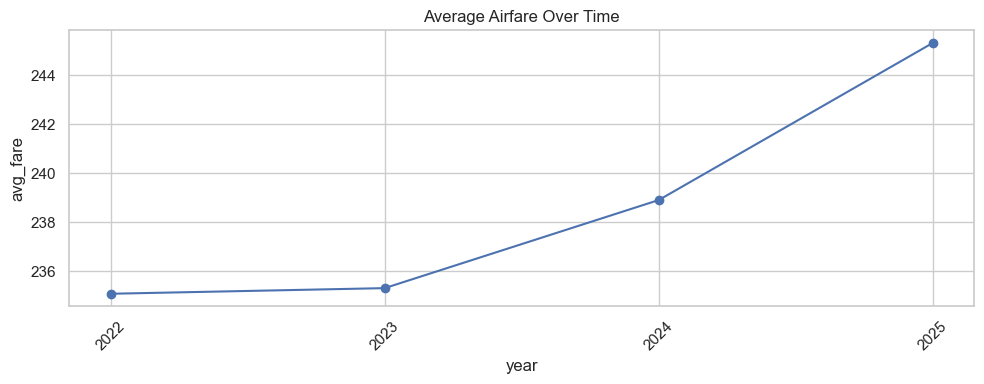

In [ ]:
# Plot: Average fare over time (adjust x/y to your column names)
if time_cols and fare_col:
    temporal = df.groupby(time_cols[0])[fare_col].mean().reset_index()
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(temporal[time_cols[0]].astype(str), temporal[fare_col], marker='o')
    ax.set_title('Average Airfare Over Time')
    ax.set_xlabel(time_cols[0])
    ax.set_ylabel(fare_col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('Skipping temporal plot: need fare and time columns.')

## 4. Where Do Fares Differ? — Routes & City-Level Effects

In [19]:
# Origin/destination columns
origin_col = next((c for c in df.columns if 'origin' in c.lower()), None)
dest_col = next((c for c in df.columns if 'dest' in c.lower() or 'destination' in c.lower()), None)
if not origin_col:
    origin_col = df.columns[0]
if not dest_col:
    dest_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]
print('Origin column:', origin_col, '| Dest column:', dest_col)

# Route-level average fare
route_cols = [c for c in [origin_col, dest_col] if c]
if len(route_cols) >= 2:
    route_fare = df.groupby(route_cols)[fare_col].agg(['mean','count']).reset_index()
    route_fare = route_fare[route_fare['count'] >= 10].sort_values('mean', ascending=False)
    print('Top 10 most expensive routes (min 10 obs):')
    print(route_fare.head(10))
    print('\nTop 10 cheapest routes:')
    print(route_fare.tail(10))

Origin column: origin | Dest column: dest
Top 10 most expensive routes (min 10 obs):
                                     origin  \
1057  New York City, NY (Metropolitan Area)   
873     Los Angeles, CA (Metropolitan Area)   
607                             Detroit, MI   
86          Atlanta, GA (Metropolitan Area)   
602                             Detroit, MI   
604                             Detroit, MI   
85          Atlanta, GA (Metropolitan Area)   
313                           Charlotte, NC   
1225  San Francisco, CA (Metropolitan Area)   
1065  New York City, NY (Metropolitan Area)   

                                       dest        mean  count  
1057  San Francisco, CA (Metropolitan Area)  420.367143     14  
873   New York City, NY (Metropolitan Area)  412.230714     14  
607   San Francisco, CA (Metropolitan Area)  408.070000     14  
86                       Salt Lake City, UT  405.357857     14  
602                            Portland, OR  399.234000     10  
604    

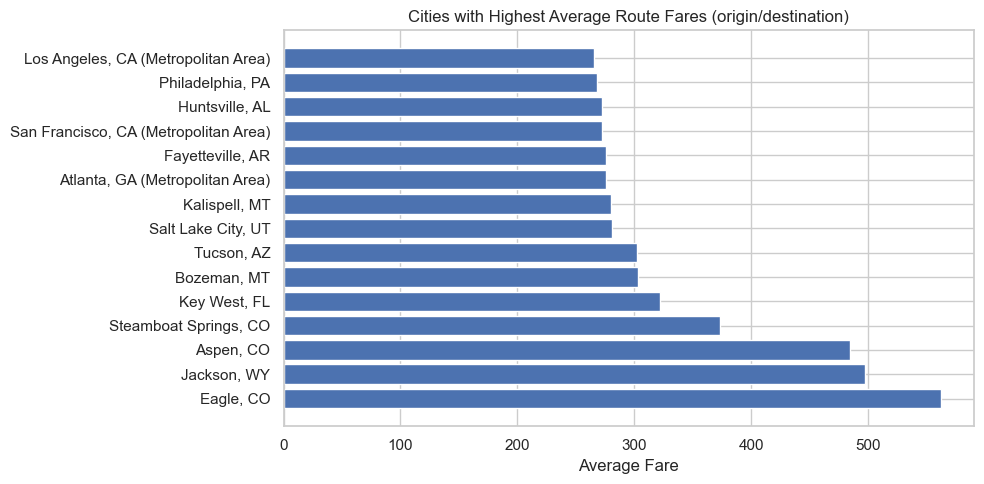

In [20]:
# City-level: average fare when city is origin or destination
if origin_col and dest_col and fare_col:
    orig_fare = df.groupby(origin_col)[fare_col].mean().reset_index().rename(columns={origin_col: 'city', fare_col: 'avg_fare_origin'})
    dest_fare = df.groupby(dest_col)[fare_col].mean().reset_index().rename(columns={dest_col: 'city', fare_col: 'avg_fare_dest'})
    city_fare = orig_fare.merge(dest_fare, on='city', how='outer')
    city_fare['avg_fare'] = city_fare[['avg_fare_origin','avg_fare_dest']].mean(axis=1)
    city_fare = city_fare.nlargest(15, 'avg_fare')
    fig, ax = plt.subplots(figsize=(10,5))
    ax.barh(city_fare['city'].astype(str), city_fare['avg_fare'])
    ax.set_title('Cities with Highest Average Route Fares (origin/destination)')
    ax.set_xlabel('Average Fare')
    plt.tight_layout()
    plt.show()

## 5. Why Do Fares Differ? — Competition, Hub Dominance, LCC Penetration

In [21]:
# Competition / dominance: correlate fare with market share, LCC, number of carriers
numeric = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns:', numeric)
if fare_col in df.columns and len(numeric) > 1:
    corr_ser = df[numeric].corr()[fare_col].drop(fare_col, errors='ignore')
    corr = corr_ser.reindex(corr_ser.abs().sort_values(ascending=False).index)
    print('\nCorrelation with', fare_col, ':')
    print(corr.head(15))

Numeric columns: ['year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'distance', 'passengers', 'avg_fare', 'dom_share', 'fare_lg', 'lcc_share', 'fare_low', 'TotalFaredPax_city1', 'TotalPerLFMkts_city1', 'TotalPerPrem_city1', 'TotalFaredPax_city2', 'TotalPerLFMkts_city2', 'TotalPerPrem_city2']

Correlation with avg_fare :
fare_lg                 0.902834
fare_low                0.705821
distance                0.677542
lcc_share              -0.317175
TotalPerPrem_city1      0.309118
TotalPerPrem_city2      0.234077
TotalPerLFMkts_city2   -0.096281
dom_share              -0.095446
passengers             -0.078316
TotalPerLFMkts_city1   -0.072546
year                    0.049630
citymarketid_1          0.022289
quarter                 0.021664
TotalFaredPax_city1     0.019734
TotalFaredPax_city2     0.011579
Name: avg_fare, dtype: float64


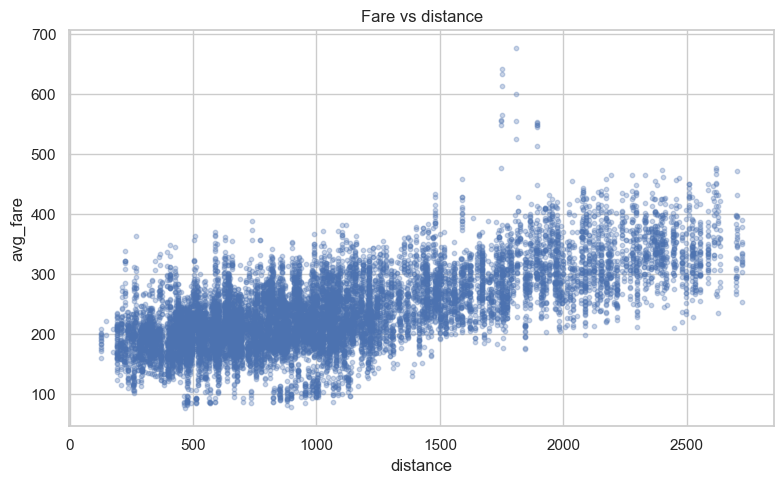

In [22]:
# Scatter: fare vs one key driver (e.g. distance or dominant share)
x_col = next((c for c in df.columns if 'distance' in c.lower() or 'mile' in c.lower()), None)
if not x_col and numeric:
    x_col = [c for c in numeric if c != fare_col]
    x_col = x_col[0] if x_col else None
if x_col and fare_col:
    plt.figure(figsize=(8,5))
    plt.scatter(df[x_col], df[fare_col], alpha=0.3, s=10)
    plt.xlabel(x_col)
    plt.ylabel(fare_col)
    plt.title(f'Fare vs {x_col}')
    plt.tight_layout()
    plt.show()

## Enhanced EDA — Fare Distribution, Distance & Fare-per-Mile

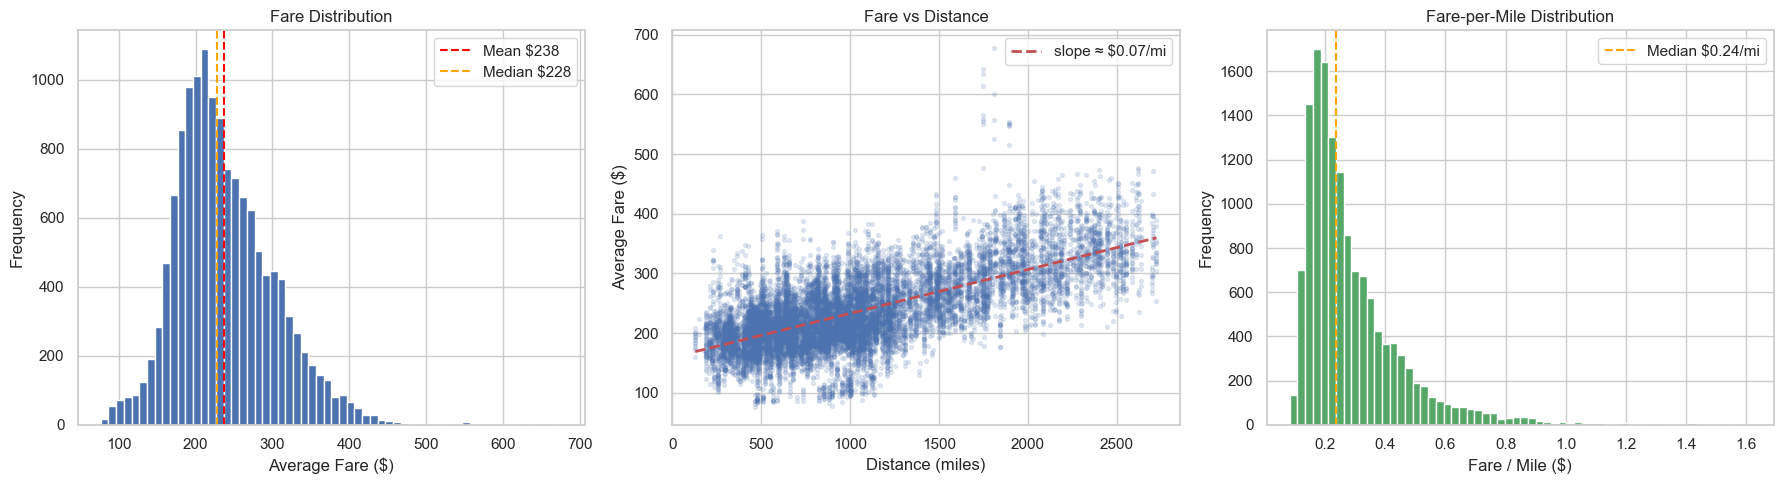


Fare summary: mean=$237.70, median=$227.64, std=$63.93
Fare-per-mile: mean=$0.29, median=$0.24


In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Fare distribution
axes[0].hist(df['avg_fare'], bins=60, edgecolor='white', color='#4C72B0')
axes[0].axvline(df['avg_fare'].mean(), color='red', ls='--',
                label=f"Mean ${df['avg_fare'].mean():.0f}")
axes[0].axvline(df['avg_fare'].median(), color='orange', ls='--',
                label=f"Median ${df['avg_fare'].median():.0f}")
axes[0].set_title('Fare Distribution')
axes[0].set_xlabel('Average Fare ($)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Fare vs Distance with trend line
axes[1].scatter(df['distance'], df['avg_fare'], alpha=0.15, s=8, c='#4C72B0')
z = np.polyfit(df['distance'], df['avg_fare'], 1)
x_line = np.linspace(df['distance'].min(), df['distance'].max(), 100)
axes[1].plot(x_line, np.polyval(z, x_line), 'r--', lw=2,
             label=f'slope ≈ ${z[0]:.2f}/mi')
axes[1].set_title('Fare vs Distance')
axes[1].set_xlabel('Distance (miles)')
axes[1].set_ylabel('Average Fare ($)')
axes[1].legend()

# Fare-per-mile distribution
df['fare_per_mile'] = df['avg_fare'] / df['distance']
axes[2].hist(df['fare_per_mile'], bins=60, edgecolor='white', color='#55A868')
axes[2].axvline(df['fare_per_mile'].median(), color='orange', ls='--',
                label=f"Median ${df['fare_per_mile'].median():.2f}/mi")
axes[2].set_title('Fare-per-Mile Distribution')
axes[2].set_xlabel('Fare / Mile ($)')
axes[2].set_ylabel('Frequency')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\nFare summary: mean=${df['avg_fare'].mean():.2f}, "
      f"median=${df['avg_fare'].median():.2f}, std=${df['avg_fare'].std():.2f}")
print(f"Fare-per-mile: mean=${df['fare_per_mile'].mean():.2f}, "
      f"median=${df['fare_per_mile'].median():.2f}")

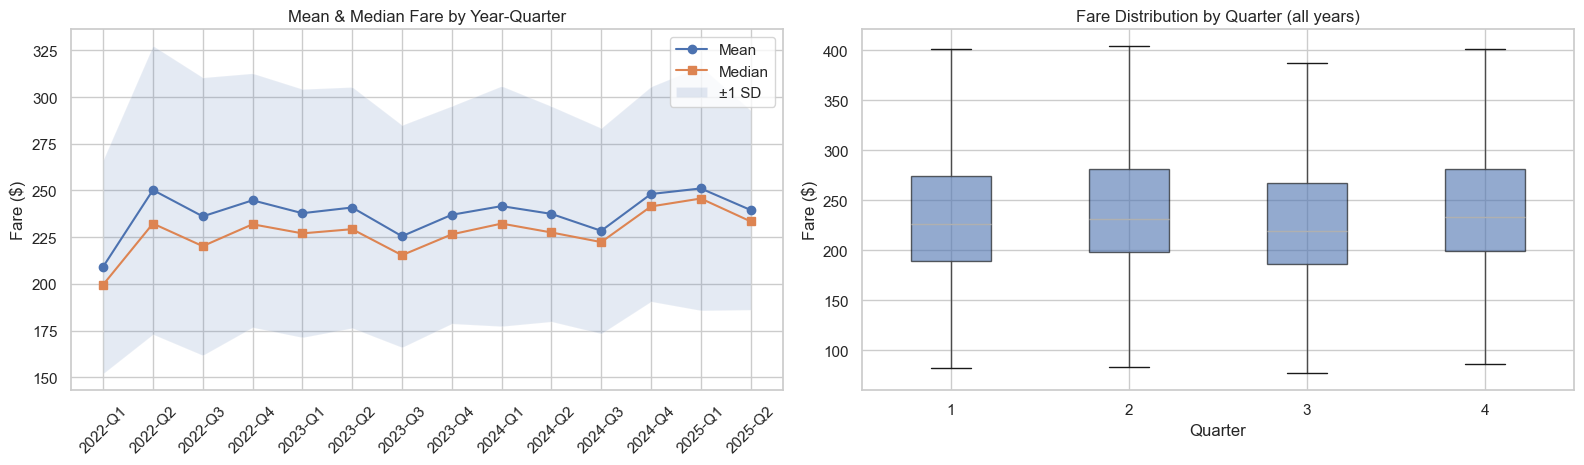

In [26]:
yq_label = df['year'].astype(str) + '-Q' + df['quarter'].astype(str)
yq_order = sorted(yq_label.unique(), key=lambda x: (int(x[:4]), int(x[-1])))
df['yq'] = pd.Categorical(yq_label, categories=yq_order, ordered=True)

temporal = (
    df.groupby('yq', observed=True)['avg_fare']
    .agg(['mean', 'median', 'std', 'count'])
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(temporal['yq'].astype(str), temporal['mean'], marker='o', label='Mean')
axes[0].plot(temporal['yq'].astype(str), temporal['median'], marker='s', label='Median')
axes[0].fill_between(
    range(len(temporal)),
    temporal['mean'] - temporal['std'],
    temporal['mean'] + temporal['std'],
    alpha=0.15, label='±1 SD'
)
axes[0].set_title('Mean & Median Fare by Year-Quarter')
axes[0].set_ylabel('Fare ($)')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

bp = df.boxplot(column='avg_fare', by='quarter', ax=axes[1],
                patch_artist=True, showfliers=False,
                boxprops=dict(facecolor='#4C72B0', alpha=0.6))
axes[1].set_title('Fare Distribution by Quarter (all years)')
axes[1].set_xlabel('Quarter')
axes[1].set_ylabel('Fare ($)')
fig.suptitle('')
plt.tight_layout()
plt.show()

## Market Structure Deep-Dive — Hub Dominance, LCC Penetration & Fare Dynamics

We engineer route-level features from the city-level endpoint data, then examine how hub intensity, low-cost-carrier penetration, and dominant-carrier market power relate to fares.

In [27]:
hub_score = (df['TotalFaredPax_city1'].fillna(0) + df['TotalFaredPax_city2'].fillna(0)) / 2
df['hub_score'] = hub_score

df['avg_lcc_penetration'] = (
    df['TotalPerLFMkts_city1'].fillna(0) + df['TotalPerLFMkts_city2'].fillna(0)
) / 2

df['avg_fare_premium'] = (
    df['TotalPerPrem_city1'].fillna(0) + df['TotalPerPrem_city2'].fillna(0)
) / 2

df['fare_spread'] = df['fare_lg'] - df['fare_low']

df['competition_ratio'] = df['lcc_share'] / df['dom_share'].replace(0, np.nan)

df['hub_tier'] = pd.qcut(
    df['hub_score'], q=4,
    labels=['Low-Hub', 'Mid-Low', 'Mid-High', 'Major-Hub']
)

df['lcc_tier'] = pd.qcut(
    df['avg_lcc_penetration'], q=4,
    labels=['Low-LCC', 'Mid-Low', 'Mid-High', 'High-LCC']
)

print('Engineered features summary:')
df[['avg_fare', 'hub_score', 'avg_lcc_penetration', 'avg_fare_premium',
    'fare_spread', 'competition_ratio']].describe().round(2)

Engineered features summary:


,avg_fare,hub_score,avg_lcc_penetration,avg_fare_premium,fare_spread,competition_ratio
count,14004.00,14004.00,14004.00,14004.00,14004.00,14004.00
mean,237.70,3084511.42,0.83,-0.02,64.76,0.60
std,63.93,1311855.79,0.10,0.08,69.76,0.34
min,76.77,221595.00,0.26,-0.54,0.00,0.01
25%,193.09,2074053.12,0.79,-0.06,0.00,0.30
50%,227.64,2823143.75,0.86,-0.01,47.68,0.56
75%,275.62,3956813.12,0.90,0.03,106.16,1.00
max,676.89,8704000.00,0.99,0.48,384.93,1.00


### Hub Dominance vs Fare

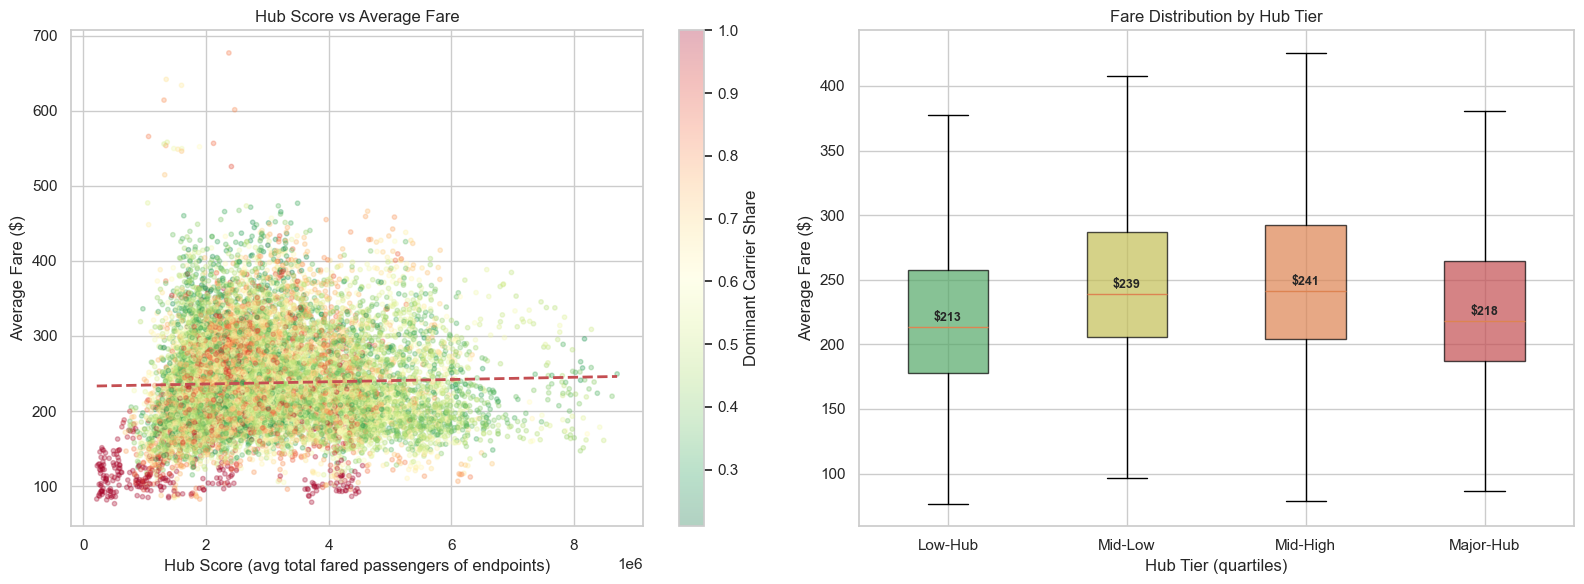


Median fare by hub tier:
           median    mean  count
hub_tier                        
Low-Hub    213.27  221.94   3501
Mid-Low    238.90  248.49   3501
Mid-High   241.27  251.30   3501
Major-Hub  217.82  229.07   3501


In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

mask = df['hub_score'].notna() & df['avg_fare'].notna()
sc = axes[0].scatter(
    df.loc[mask, 'hub_score'], df.loc[mask, 'avg_fare'],
    c=df.loc[mask, 'dom_share'], cmap='RdYlGn_r', alpha=0.3, s=10
)
z = np.polyfit(df.loc[mask, 'hub_score'], df.loc[mask, 'avg_fare'], 1)
x_line = np.linspace(df['hub_score'].min(), df['hub_score'].max(), 100)
axes[0].plot(x_line, np.polyval(z, x_line), 'r--', lw=2)
axes[0].set_title('Hub Score vs Average Fare')
axes[0].set_xlabel('Hub Score (avg total fared passengers of endpoints)')
axes[0].set_ylabel('Average Fare ($)')
plt.colorbar(sc, ax=axes[0], label='Dominant Carrier Share')

tiers = ['Low-Hub', 'Mid-Low', 'Mid-High', 'Major-Hub']
hub_data = [df.loc[df['hub_tier'] == t, 'avg_fare'].dropna() for t in tiers]
bp = axes[1].boxplot(hub_data, labels=tiers, patch_artist=True, showfliers=False)
colors = ['#55A868', '#C4BF56', '#DD8452', '#C44E52']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
for i, t in enumerate(tiers):
    med = df.loc[df['hub_tier'] == t, 'avg_fare'].median()
    axes[1].text(i + 1, med + 5, f'${med:.0f}', ha='center', fontsize=9, fontweight='bold')
axes[1].set_title('Fare Distribution by Hub Tier')
axes[1].set_ylabel('Average Fare ($)')
axes[1].set_xlabel('Hub Tier (quartiles)')

plt.tight_layout()
plt.show()

print('\nMedian fare by hub tier:')
print(df.groupby('hub_tier', observed=True)['avg_fare']
      .agg(['median', 'mean', 'count']).round(2))

### LCC Penetration vs Fare

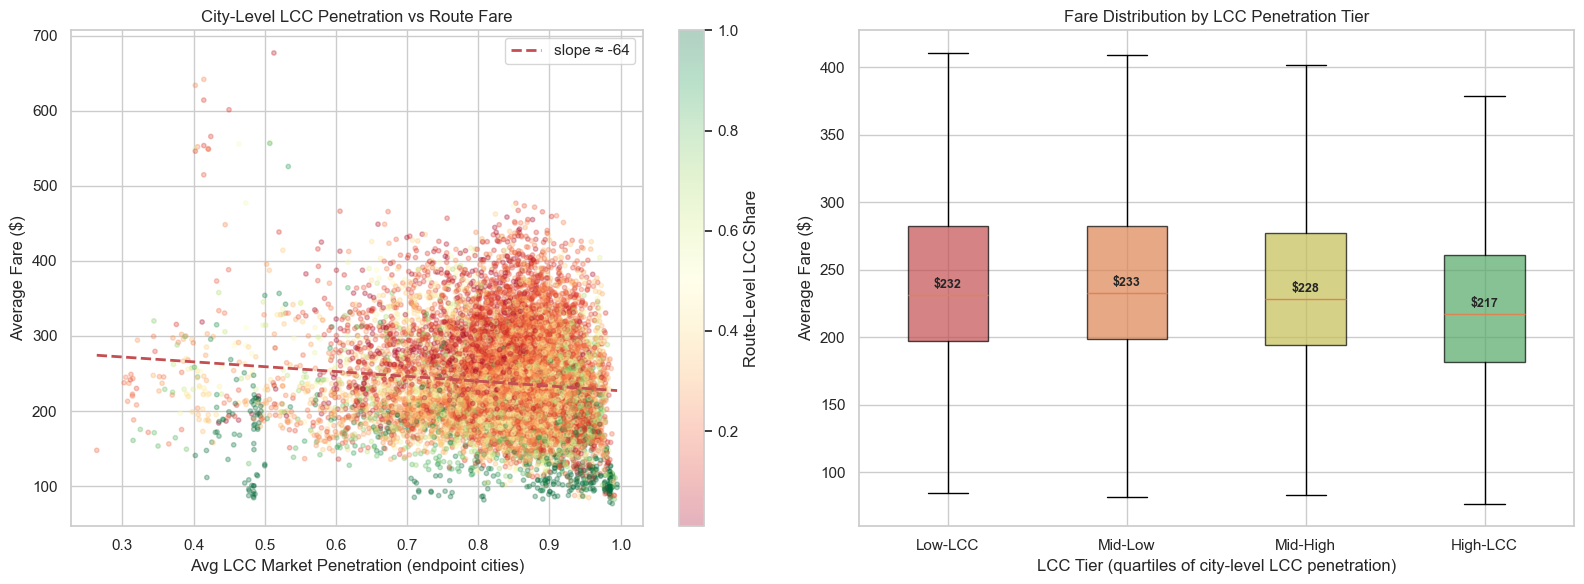


Median fare by LCC penetration tier:
          median    mean  count
lcc_tier                       
Low-LCC   231.57  244.22   3501
Mid-Low   233.14  243.98   3502
Mid-High  228.26  238.99   3500
High-LCC  217.16  223.59   3501


In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

mask = df['avg_lcc_penetration'].notna() & df['avg_fare'].notna()
sc = axes[0].scatter(
    df.loc[mask, 'avg_lcc_penetration'], df.loc[mask, 'avg_fare'],
    c=df.loc[mask, 'lcc_share'], cmap='RdYlGn', alpha=0.3, s=10
)
z = np.polyfit(df.loc[mask, 'avg_lcc_penetration'], df.loc[mask, 'avg_fare'], 1)
x_line = np.linspace(df['avg_lcc_penetration'].min(), df['avg_lcc_penetration'].max(), 100)
axes[0].plot(x_line, np.polyval(z, x_line), 'r--', lw=2,
             label=f'slope ≈ {z[0]:.0f}')
axes[0].set_title('City-Level LCC Penetration vs Route Fare')
axes[0].set_xlabel('Avg LCC Market Penetration (endpoint cities)')
axes[0].set_ylabel('Average Fare ($)')
axes[0].legend()
plt.colorbar(sc, ax=axes[0], label='Route-Level LCC Share')

lcc_tiers = ['Low-LCC', 'Mid-Low', 'Mid-High', 'High-LCC']
lcc_data = [df.loc[df['lcc_tier'] == t, 'avg_fare'].dropna() for t in lcc_tiers]
bp = axes[1].boxplot(lcc_data, labels=lcc_tiers, patch_artist=True, showfliers=False)
colors = ['#C44E52', '#DD8452', '#C4BF56', '#55A868']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
for i, t in enumerate(lcc_tiers):
    med = df.loc[df['lcc_tier'] == t, 'avg_fare'].median()
    axes[1].text(i + 1, med + 5, f'${med:.0f}', ha='center', fontsize=9, fontweight='bold')
axes[1].set_title('Fare Distribution by LCC Penetration Tier')
axes[1].set_ylabel('Average Fare ($)')
axes[1].set_xlabel('LCC Tier (quartiles of city-level LCC penetration)')

plt.tight_layout()
plt.show()

print('\nMedian fare by LCC penetration tier:')
print(df.groupby('lcc_tier', observed=True)['avg_fare']
      .agg(['median', 'mean', 'count']).round(2))

### Dominant Carrier Share vs Fare & Correlation Heatmap

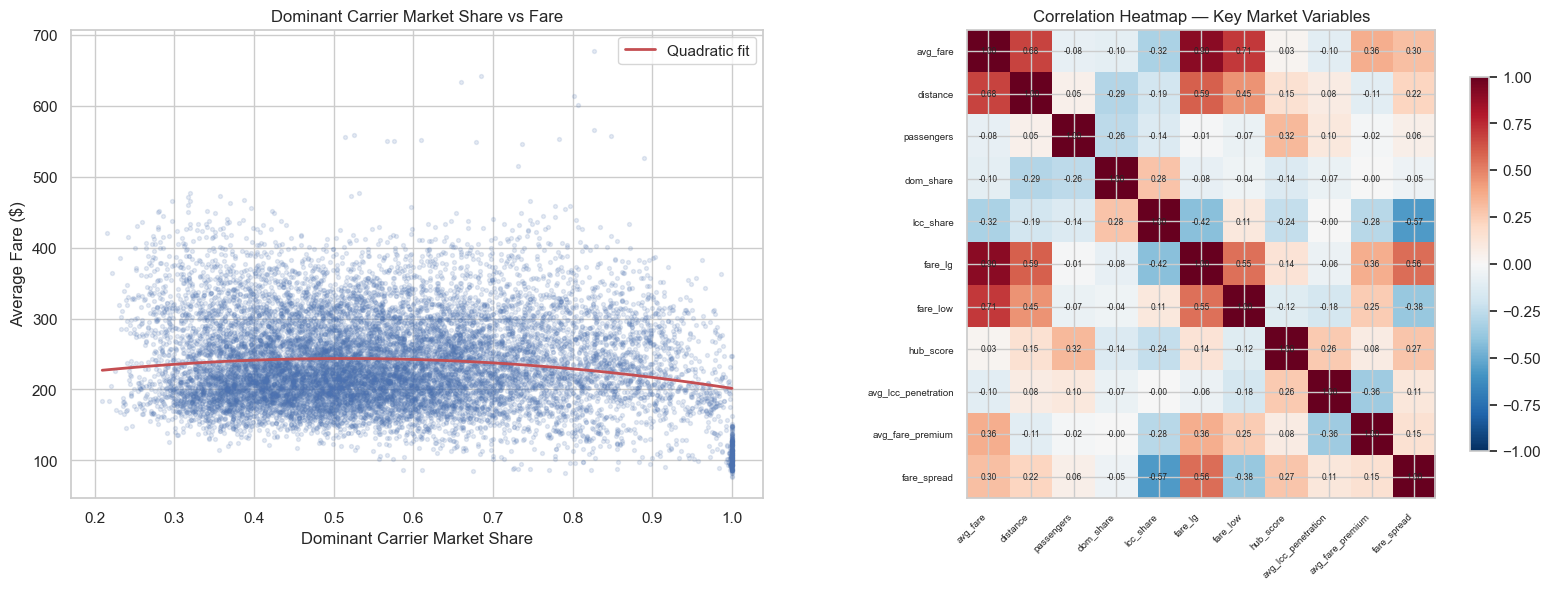

Correlation with avg_fare (by |r|):
  fare_lg                   +0.903
  fare_low                  +0.706
  distance                  +0.678
  avg_fare_premium          +0.364
  lcc_share                 -0.317
  fare_spread               +0.303
  avg_lcc_penetration       -0.102
  dom_share                 -0.095
  passengers                -0.078
  hub_score                 +0.031


In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Dominant carrier share vs fare (quadratic fit captures U-shape)
axes[0].scatter(df['dom_share'], df['avg_fare'], alpha=0.15, s=8, c='#4C72B0')
z = np.polyfit(df['dom_share'], df['avg_fare'], 2)
x_line = np.linspace(df['dom_share'].min(), df['dom_share'].max(), 100)
axes[0].plot(x_line, np.polyval(z, x_line), 'r-', lw=2, label='Quadratic fit')
axes[0].set_title('Dominant Carrier Market Share vs Fare')
axes[0].set_xlabel('Dominant Carrier Market Share')
axes[0].set_ylabel('Average Fare ($)')
axes[0].legend()

# Correlation heatmap of key variables
key_vars = ['avg_fare', 'distance', 'passengers', 'dom_share', 'lcc_share',
            'fare_lg', 'fare_low', 'hub_score', 'avg_lcc_penetration',
            'avg_fare_premium', 'fare_spread']
corr = df[key_vars].corr()
im = axes[1].imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1].set_xticks(range(len(key_vars)))
axes[1].set_yticks(range(len(key_vars)))
axes[1].set_xticklabels(key_vars, rotation=45, ha='right', fontsize=7)
axes[1].set_yticklabels(key_vars, fontsize=7)
for i in range(len(key_vars)):
    for j in range(len(key_vars)):
        axes[1].text(j, i, f'{corr.iloc[i, j]:.2f}',
                     ha='center', va='center', fontsize=6)
plt.colorbar(im, ax=axes[1], shrink=0.8)
axes[1].set_title('Correlation Heatmap — Key Market Variables')

plt.tight_layout()
plt.show()

fare_corr = corr['avg_fare'].drop('avg_fare').sort_values(key=abs, ascending=False)
print('Correlation with avg_fare (by |r|):')
for var, val in fare_corr.items():
    print(f'  {var:25s} {val:+.3f}')

### Joint Effect — Hub Tier × LCC Tier on Fares

Median Fare ($) — Hub Tier × LCC Tier:

lcc_tier   Low-LCC  Mid-Low  Mid-High  High-LCC
hub_tier                                       
Low-Hub      220.6    214.8     211.1     197.7
Mid-Low      231.0    247.9     239.1     234.4
Mid-High     243.0    245.0     244.0     229.4
Major-Hub    245.2    218.7     217.9     211.2

Avg fare gap (Low-LCC vs High-LCC across hub tiers): $17


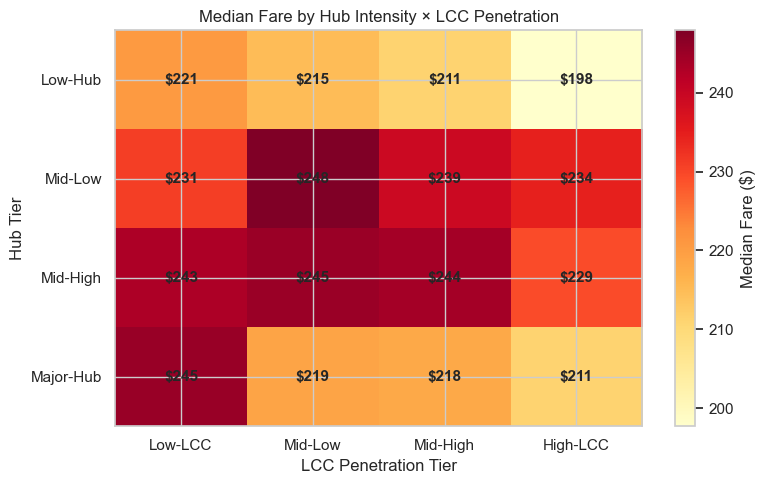

In [31]:
pivot = df.pivot_table(
    values='avg_fare', index='hub_tier', columns='lcc_tier',
    aggfunc='median', observed=True
).round(1)

print('Median Fare ($) — Hub Tier × LCC Tier:\n')
print(pivot)

low_lcc_avg = pivot.iloc[:, 0].mean()
high_lcc_avg = pivot.iloc[:, -1].mean()
print(f'\nAvg fare gap (Low-LCC vs High-LCC across hub tiers): '
      f'${low_lcc_avg - high_lcc_avg:.0f}')

fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(pivot.values, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(len(pivot.columns)))
ax.set_yticks(range(len(pivot.index)))
ax.set_xticklabels(pivot.columns)
ax.set_yticklabels(pivot.index)
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        ax.text(j, i, f'${pivot.values[i, j]:.0f}',
                ha='center', va='center', fontweight='bold', fontsize=11)
plt.colorbar(im, ax=ax, label='Median Fare ($)')
ax.set_title('Median Fare by Hub Intensity × LCC Penetration')
ax.set_xlabel('LCC Penetration Tier')
ax.set_ylabel('Hub Tier')
plt.tight_layout()
plt.show()

### Fare Spread — How Much More Does the Dominant Carrier Charge?

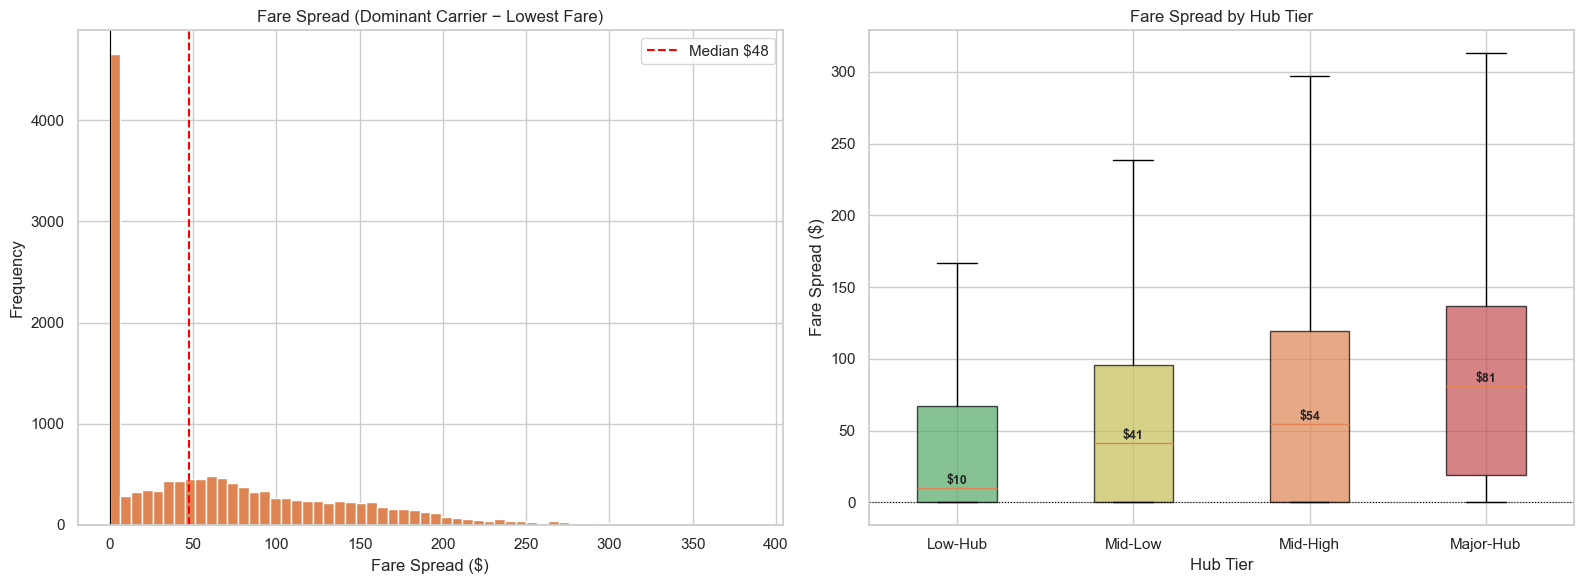

31.2% of routes have zero spread (dominant carrier IS the lowest-fare carrier)
Median spread: $47.67
Mean spread:   $64.76


In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fare spread distribution
axes[0].hist(df['fare_spread'], bins=60, edgecolor='white', color='#DD8452')
axes[0].axvline(0, color='black', ls='-', lw=0.8)
axes[0].axvline(df['fare_spread'].median(), color='red', ls='--',
                label=f"Median ${df['fare_spread'].median():.0f}")
axes[0].set_title('Fare Spread (Dominant Carrier − Lowest Fare)')
axes[0].set_xlabel('Fare Spread ($)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Fare spread by hub tier
tiers = ['Low-Hub', 'Mid-Low', 'Mid-High', 'Major-Hub']
spread_data = [df.loc[df['hub_tier'] == t, 'fare_spread'].dropna() for t in tiers]
bp = axes[1].boxplot(spread_data, labels=tiers, patch_artist=True, showfliers=False)
colors = ['#55A868', '#C4BF56', '#DD8452', '#C44E52']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
for i, t in enumerate(tiers):
    med = df.loc[df['hub_tier'] == t, 'fare_spread'].median()
    axes[1].text(i + 1, med + 3, f'${med:.0f}', ha='center', fontsize=9, fontweight='bold')
axes[1].axhline(0, color='black', ls=':', lw=0.8)
axes[1].set_title('Fare Spread by Hub Tier')
axes[1].set_ylabel('Fare Spread ($)')
axes[1].set_xlabel('Hub Tier')

plt.tight_layout()
plt.show()

pct_zero = (df['fare_spread'] == 0).mean() * 100
print(f'{pct_zero:.1f}% of routes have zero spread '
      f'(dominant carrier IS the lowest-fare carrier)')
print(f'Median spread: ${df["fare_spread"].median():.2f}')
print(f'Mean spread:   ${df["fare_spread"].mean():.2f}')

## 6. Predictive Model — Explaining Fare Variation

In [23]:
# Prepare model matrix: numeric + encoded categoricals
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

model_df = df.copy()
for col in model_df.select_dtypes(include=['object']).columns:
    if model_df[col].nunique() < 100 and model_df[col].notna().sum() > 100:
        model_df[col] = LabelEncoder().fit_transform(model_df[col].astype(str))
    else:
        model_df = model_df.drop(columns=[col], errors='ignore')
model_df = model_df.select_dtypes(include=[np.number]).dropna(how='all', axis=1)
if fare_col not in model_df.columns:
    fare_col = next((c for c in df.columns if 'fare' in c.lower()), model_df.columns[0])
    model_df[fare_col] = df[fare_col]
y = model_df[fare_col]
X = model_df.drop(columns=[fare_col], errors='ignore').dropna(axis=1, how='all')
X = X.loc[:, X.nunique() > 1]
# Drop rows with any NaN so LinearRegression can run
valid = X.notna().all(axis=1) & y.notna()
X, y = X.loc[valid], y.loc[valid]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
pred = reg.predict(X_test)
print('MAE:', round(mean_absolute_error(y_test, pred), 2))
print('R²:', round(r2_score(y_test, pred), 4))
coef = pd.Series(reg.coef_, index=X.columns).reindex(
    pd.Series(reg.coef_, index=X.columns).abs().sort_values(ascending=False).index
)
print('\nTop feature importance (coefficient magnitude):')
print(coef.head(15))

MAE: 13.48
R²: 0.9241

Top feature importance (coefficient magnitude):
TotalPerPrem_city1      50.290017
TotalPerPrem_city2      47.230589
lcc_share              -20.583952
dom_share               16.260332
TotalPerLFMkts_city2     9.670747
TotalPerLFMkts_city1    -3.607305
quarter                  1.432277
year                     0.791193
dominant_carrier         0.560530
fare_lg                  0.451068
fare_low                 0.229906
lowest_fare_carrier      0.072328
distance                 0.029818
passengers              -0.001928
citymarketid_2          -0.000804
dtype: float64


## 7. Summary & Actionable Insights

In [24]:
print('''
--- ACTIONABLE INSIGHTS ---

1. TRAVELERS: Use route and time patterns above to prefer cheaper city-pairs and booking windows.
2. INDUSTRY: Hub dominance and LCC penetration drive fares; position on high-fare vs competitive routes.
3. POLICY: Monitor high-fare, low-competition markets for consumer protection and competition.
4. Re-run this notebook after aligning column names (Section 2) to your actual DOT dataset.
''')


--- ACTIONABLE INSIGHTS ---

1. TRAVELERS: Use route and time patterns above to prefer cheaper city-pairs and booking windows.
2. INDUSTRY: Hub dominance and LCC penetration drive fares; position on high-fare vs competitive routes.
3. POLICY: Monitor high-fare, low-competition markets for consumer protection and competition.
4. Re-run this notebook after aligning column names (Section 2) to your actual DOT dataset.

